# Test out nilearn's BIDS output function

This notebook copies [Example 9.5.7](https://nilearn.github.io/auto_examples/04_glm_first_level/plot_spm_multimodal_faces.html#single-subject-data-two-sessions-in-native-space) for the modeling code, then writes out the files with the new `save_glm_results` function.

In [1]:
import json
import os.path as op
from glob import glob
from pprint import pprint

import nibabel as nib
import numpy as np
import pandas as pd

from nilearn.datasets import fetch_spm_multimodal_fmri
from nilearn.reporting import save_glm_results
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img

/Users/taylor/Documents/tsalo/nilearn/nilearn/datasets/__init__.py:92: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
subject_data = fetch_spm_multimodal_fmri()

tr = 2.  # repetition time, in seconds
slice_time_ref = 0.  # we will sample the design matrix at the beggining of each acquisition
drift_model = 'Cosine'  # We use a discrete cosine transform to model signal drifts.
high_pass = .01  # The cutoff for the drift model is 0.01 Hz.
hrf_model = 'spm + derivative'  # The hemodynamic response function is the SPM canonical one.

In [3]:
filenames = [
    "/Users/taylor/Desktop/nilearn-output/DATA_RUN1.nii.gz",
    "/Users/taylor/Desktop/nilearn-output/DATA_RUN2.nii.gz",
]
out_dir = "/Users/taylor/Desktop/nilearn-output/"
prefix = "sub-01_task-multimodalFace"

# Just load the concatenated/resampled files if they're available
if not op.isfile(filenames[1]):
    fmri_img = [concat_imgs(subject_data.func1, auto_resample=True),
                concat_imgs(subject_data.func2, auto_resample=True)]
    affine, shape = fmri_img[0].affine, fmri_img[0].shape
    print('Resampling the second image (this takes time)...')
    fmri_img[1] = resample_img(fmri_img[1], affine, shape[:3])
    fmri_img[0].to_filename(filenames[0])
    fmri_img[1].to_filename(filenames[1])
else:
    fmri_img = [nib.load(f) for f in filenames]

In [4]:
# Define the design matrices
design_matrices = []

for idx, img in enumerate(fmri_img, start=1):
    # Build experimental paradigm
    n_scans = img.shape[-1]
    events = pd.read_table(subject_data['events{}'.format(idx)])
    # Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    # Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
            frame_times,
            events,
            hrf_model=hrf_model,
            drift_model=drift_model,
            high_pass=high_pass,
            )

    # put the design matrices in a list
    design_matrices.append(design_matrix)
    
# Define the contrasts
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])

contrasts = {
    'faces-scrambled': basic_contrasts['faces'] - basic_contrasts['scrambled'],
    'scrambled-faces': -basic_contrasts['faces'] + basic_contrasts['scrambled'],
    'effects_of_interest': np.vstack((basic_contrasts['faces'],
                                      basic_contrasts['scrambled']))
}

# Fit the GLM
fmri_glm = FirstLevelModel(minimize_memory=False)
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrices)

/Users/taylor/Documents/tsalo/nilearn/nilearn/reporting/glm_reporter.py:1016: UserWarning: Contrast name "faces-scrambled" changed to "facesMinusScrambled"
  warnings.warn(
/Users/taylor/Documents/tsalo/nilearn/nilearn/reporting/glm_reporter.py:1016: UserWarning: Contrast name "scrambled-faces" changed to "scrambledMinusFaces"
  warnings.warn(
/Users/taylor/Documents/tsalo/nilearn/nilearn/reporting/glm_reporter.py:1016: UserWarning: Contrast name "effects_of_interest" changed to "effectsOfInterest"
  warnings.warn(
/Users/taylor/Documents/tsalo/nilearn/nilearn/glm/first_level/first_level.py:652: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/Users/taylor/Documents/tsalo/nilearn/nilearn/glm/contrasts.py:352: UserWarning: Running approximate fixed effects on F statistics.
  warn('Running approximate fixed effects on F statistics.')


Extracting and saving residuals


/Users/taylor/Documents/tsalo/nilearn/nilearn/glm/regression.py:42: FutureWarning: 'resid' has been deprecated in version 0.7.0 and will be removed in version 0.9.0. Please use 'residuals' instead.
  warnings.warn(category=FutureWarning,


Extracting and saving r_square


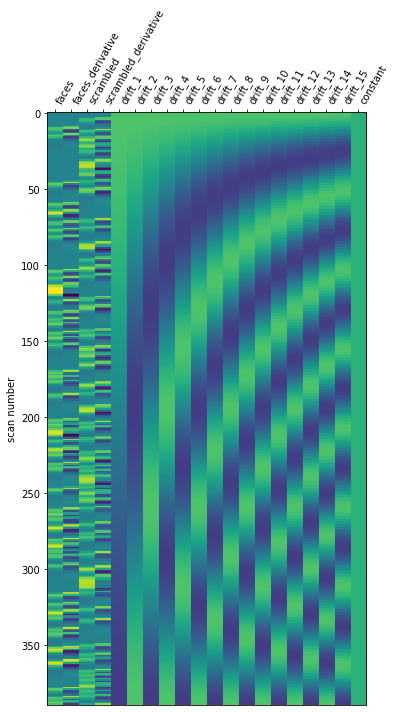

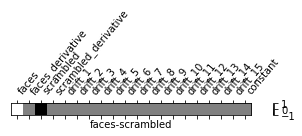

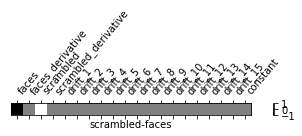

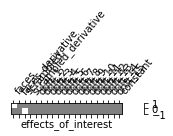

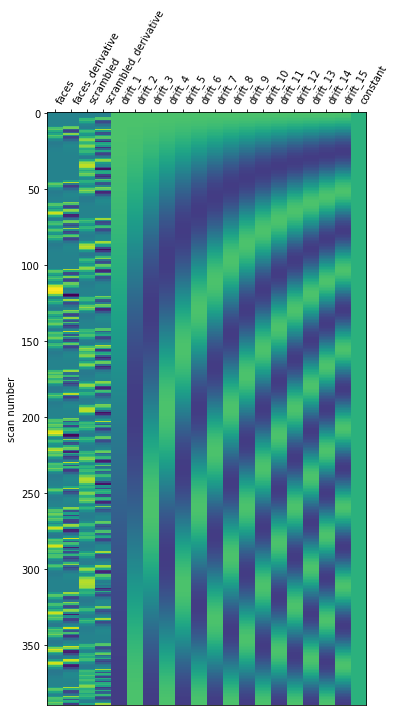

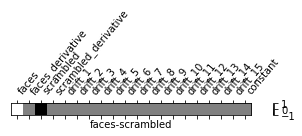

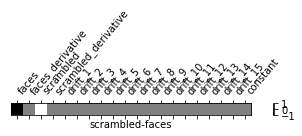

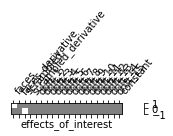

In [5]:
# And now, for the moment of truth...
save_glm_results(
    fmri_glm, 
    contrasts, 
    out_dir=out_dir, 
    prefix=prefix,
)

## Let's see what files were created

In [6]:
output_files = sorted(glob(op.join(out_dir, "*")))
output_files = [op.basename(f) for f in output_files]
output_files = [f for f in output_files if not f.startswith("DATA_RUN")]
print("\n".join(output_files))

dataset_description.json
sub-01_task-multimodalFace_contrast-effectsOfInterest_stat-F_statmap.nii.gz
sub-01_task-multimodalFace_contrast-effectsOfInterest_stat-effect_statmap.nii.gz
sub-01_task-multimodalFace_contrast-effectsOfInterest_stat-p_statmap.nii.gz
sub-01_task-multimodalFace_contrast-effectsOfInterest_stat-variance_statmap.nii.gz
sub-01_task-multimodalFace_contrast-effectsOfInterest_stat-z_statmap.nii.gz
sub-01_task-multimodalFace_contrast-facesMinusScrambled_stat-effect_statmap.nii.gz
sub-01_task-multimodalFace_contrast-facesMinusScrambled_stat-p_statmap.nii.gz
sub-01_task-multimodalFace_contrast-facesMinusScrambled_stat-t_statmap.nii.gz
sub-01_task-multimodalFace_contrast-facesMinusScrambled_stat-variance_statmap.nii.gz
sub-01_task-multimodalFace_contrast-facesMinusScrambled_stat-z_statmap.nii.gz
sub-01_task-multimodalFace_contrast-scrambledMinusFaces_stat-effect_statmap.nii.gz
sub-01_task-multimodalFace_contrast-scrambledMinusFaces_stat-p_statmap.nii.gz
sub-01_task-multimod

## Let's see the contents of the json files

In [7]:
json_files = sorted(glob(op.join(out_dir, "*.json")))
for json_file in json_files:
    print(op.basename(json_file))
    print()
    with open(json_file, "r") as fo:
        metadata = json.load(fo)
    pprint(metadata)
    
    print("\n\n------------------------------------------------------------\n\n")

dataset_description.json

{'GeneratedBy': {'CodeURL': 'https://github.com/nilearn/nilearn/releases/tag/0.8.1.dev',
                 'Description': 'A nilearn first-level GLM.',
                 'Name': 'nilearn',
                 'Version': '0.8.1.dev'}}


------------------------------------------------------------


sub-01_task-multimodalFace_statmap.json

{'Description': 'A statistical map generated by nilearn.',
 'ModelParameters': {'drift_model': 'cosine',
                     'drift_order': 1,
                     'fir_delays': [0],
                     'high_pass': 0.01,
                     'hrf_model': 'glover',
                     'scaling_axis': 0,
                     'signal_scaling': True,
                     'slice_time_ref': 0.0,
                     'smoothing_fwhm': None,
                     'standardize': False,
                     'target_affine': None,
                     'target_shape': None},
 'RepetitionTime': None}


---------------------------------------